[youtube] Extracting URL: https://www.youtube.com/watch?v=NiKtZgImdlY&t=23s
[youtube] NiKtZgImdlY: Downloading webpage
[youtube] Extracting URL: https://www.youtube.com/watch?v=NHopJHSlVo4
[youtube] NHopJHSlVo4: Downloading webpage
[youtube] NiKtZgImdlY: Downloading ios player API JSON
[youtube] NiKtZgImdlY: Downloading m3u8 information
[info] NiKtZgImdlY: Downloading 1 format(s): 251
[download] /home/rudra/Documents/GitHub/Articulation-Meter/Project Files/audio/audio_analysis/NiKtZgImdlY&t=23s.wav has already been downloaded
[ExtractAudio] Destination: /home/rudra/Documents/GitHub/Articulation-Meter/Project Files/audio/audio_analysis/NiKtZgImdlY&t=23s.wav
Deleting original file /home/rudra/Documents/GitHub/Articulation-Meter/Project Files/audio/audio_analysis/NiKtZgImdlY&t=23s.orig.wav (pass -k to keep)
Successfully downloaded and converted: https://www.youtube.com/watch?v=NiKtZgImdlY&t=23s
[youtube] NHopJHSlVo4: Downloading ios player API JSON
[youtube] NHopJHSlVo4: Downloading m3u8 

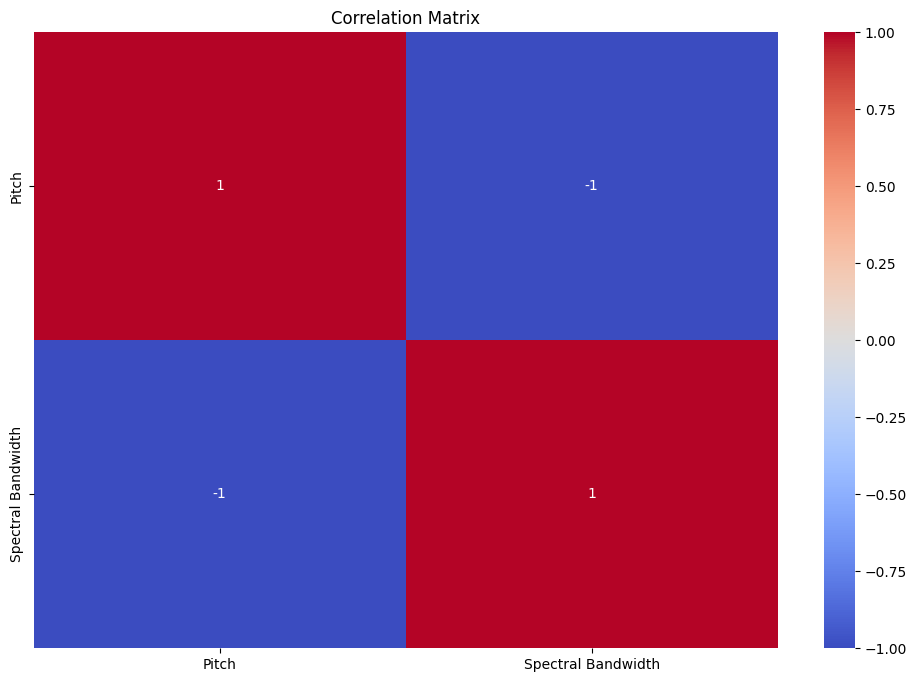

In [3]:
import os
import subprocess
import librosa
import numpy as np
import pandas as pd
from scipy.stats import variation
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import concurrent.futures
import seaborn as sns
import matplotlib.pyplot as plt

# Function to extract audio features
def extract_audio_features(audio_path):
    y, sr = librosa.load(audio_path)

    features = {}
    # features['chroma_stft'] = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
    # features['rmse'] = np.mean(librosa.feature.rms(y=y))
    # features['spectral_centroid'] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    features['spectral_bandwidth'] = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    # features['rolloff'] = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    # features['zero_crossing_rate'] = np.mean(librosa.feature.zero_crossing_rate(y))

    # Include existing features
    # features['energy'] = np.sum(librosa.stft(y) ** 2)
    # features['mfccs'] = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).mean(axis=1)
    features['pitch'] = np.max(librosa.piptrack(y=y, sr=sr)[0])
    # features['speech_rate_variation'] = variation(np.diff([d[1]-d[0] for d in librosa.effects.split(y=y)])) if len(librosa.effects.split(y=y)) > 1 else 0.0
    # features['articulation_rate'] = len(librosa.effects.split(y=y)) / librosa.get_duration(y=y)
    # features['frequency'] = sr / len(y)

    return features

# Directory to store the audio files
audio_dir = '/home/rudra/Documents/GitHub/Articulation-Meter/Project Files/audio/audio_analysis/'
os.makedirs(audio_dir, exist_ok=True)

# Function to process a single video
def process_video(video_code):
    url = f"https://www.youtube.com/watch?v={video_code}"
    output_template = os.path.join(audio_dir, f"{video_code}.%(ext)s")

    command = [
        "yt-dlp",
        "-f", "bestaudio",
        "--extract-audio",
        "--audio-format=wav",
        "-o", output_template,
        url
    ]

    try:
        subprocess.run(command, check=True)
        print(f"Successfully downloaded and converted: {url}")
    except subprocess.CalledProcessError as e:
        print(f"Failed to download {url}: {e}")

# Main code to process the two input URLs
if __name__ == '__main__':
    video_codes = [
        'NiKtZgImdlY&t=23s',  
        'NHopJHSlVo4'   
    ]
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
        executor.map(process_video, video_codes)

# Initialize lists to store results
pitches = []
# spectral_centroids = []
spectral_bandwidths = []
# rolloffs = []
# zero_crossing_rates = []

# Process each audio file in the directory corresponding to the two input URLs
audio_files_info = [(video_code, os.path.join(audio_dir, f"{video_code}.wav")) for video_code in video_codes]

for video_code, audio_path in audio_files_info:
    if os.path.exists(audio_path):
        features = extract_audio_features(audio_path)
        pitches.append(features.get('pitch', None))
        # spectral_centroids.append(features['spectral_centroid'])
        spectral_bandwidths.append(features['spectral_bandwidth'])
        # rolloffs.append(features['rolloff'])
        # zero_crossing_rates.append(features['zero_crossing_rate'])
    else:
        pitches.append(None)
        # spectral_centroids.append(None)
        spectral_bandwidths.append(None)
        # rolloffs.append(None)
        # zero_crossing_rates.append(None)

# Create a DataFrame to store the results
audio_df = pd.DataFrame({
    'Pitch': pitches,
    # 'Spectral Centroid': spectral_centroids,
    'Spectral Bandwidth': spectral_bandwidths,
    # 'Rolloff': rolloffs,
    # 'Zero Crossing Rate': zero_crossing_rates,
})

# Normalize audio features using MinMaxScaler
scaler_minmax = MinMaxScaler()
audio_df[['Pitch',  'Spectral Bandwidth']] = scaler_minmax.fit_transform(
    audio_df[['Pitch', 'Spectral Bandwidth']]
)

# Write the final DataFrame to a new Excel file
audio_df.to_excel('neg_corr.xlsx', index=False)

# Display the DataFrame to verify (optional)
print(audio_df.head())

# Load the Excel file into a pandas DataFrame for correlation analysis
file_path = 'neg_corr.xlsx'
df = pd.read_excel(file_path)

# Display the first few rows of the DataFrame
print("DataFrame loaded from Excel:")
print(df.head())

# Check for non-numeric columns and drop them before correlation computation
numeric_df = df.select_dtypes(include=[np.number])

# Standardize the numeric data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(numeric_df)
standardized_df = pd.DataFrame(standardized_data, columns=numeric_df.columns)

# Compute the correlation matrix
correlation_matrix = standardized_df.corr()

# Display the correlation matrix
print("\nCorrelation Matrix:")
print(correlation_matrix)

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()
